# Izveštaj o Projektu: Razvoj Hibridnog Sistema za Dijagnostičku Klasifikaciju Tumora Dojke

**Autor:** Konstantin Malešević, RA166/2022

**Datum:** Septembar 2025

## 1. Uvod

Ovaj izveštaj detaljno opisuje proces razvoja, evaluacije i finalne optimizacije sistema za mašinsko učenje sa ciljem klasifikacije tumora dojke kao benignih ili malignih. Projekat je zasnovan na "Breast Cancer Wisconsin (Diagnostic)" skupu podataka, koji sadrži numeričke karakteristike ćelijskih jedara dobijenih iz digitalizovanih slika biopsija.

Pristup razvoju je bio iterativan i vođen dubinskom analizom, sa primarnim ciljem ne samo da se postigne visoka tačnost, već i da se minimizira rizik od najkritičnije greške u medicinskoj dijagnostici – **lažno negativne klasifikacije (propustiti maligni tumor)**.

Izveštaj prati celokupan tok istraživanja: od početne pripreme podataka i eksplorativne analize, preko sistematskog testiranja različitih modela, do forenzičke analize grešaka i, konačno, dizajna **hibridnog sistema** koji kombinuje snagu mašinskog učenja sa ekspertskim pravilima kako bi se postigle optimalne i klinički relevantne performanse.



## 2. Učitavanje i Osnovno Čišćenje Podataka

Prvi korak u svakom projektu analize podataka je sigurno i ispravno učitavanje, kao i osnovna priprema podataka za dalju obradu.

### 2.1. Importovanje Biblioteka i Definisanje Kolona

In [3]:
# Osnovne biblioteke za manipulaciju podacima i vizuelizaciju
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Biblioteke za mašinsko učenje
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Podešavanja za prikaz
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Definišemo tačne nazive kolona prema dokumentaciji
column_names = [
    'id', 'diagnosis', 'mean radius', 'mean texture', 'mean perimeter', 'mean area',
    'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points',
    'mean symmetry', 'mean fractal dimension', 'radius se', 'texture se',
    'perimeter se', 'area se', 'smoothness se', 'compactness se', 'concavity se',
    'concave points se', 'symmetry se', 'fractal dimension se', 'worst radius',
    'worst texture', 'worst perimeter', 'worst area', 'worst smoothness',
    'worst compactness', 'worst concavity', 'worst concave points',
    'worst symmetry', 'worst fractal dimension'
]

### 2.2. Učitavanje i Pretprocesiranje

In [4]:
# Učitavanje podataka, specificirajući da nema zaglavlja i dodeljujući imena
try:
    df = pd.read_csv('../data/data.csv', header=None, names=column_names)
    print("✓ Skup podataka uspešno učitan.")
except FileNotFoundError:
    print("GREŠKA: Fajl 'data.csv' nije pronađen.")

# Uklanjanje 'id' kolone koja nije relevantna za predviđanje
df = df.drop('id', axis=1)
print("✓ Irelevantna 'id' kolona uklonjena.")

# Enkodiranje ciljne promenljive 'diagnosis' u numerički format
# Maligni (M) -> 1
# Benigni (B) -> 0
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})
print("✓ Ciljna promenljiva 'diagnosis' enkodirana (M=1, B=0).")

# Provera rezultata
print(f"\nDimenzije finalnog skupa podataka: {df.shape}")
print("\nProvera nedostajućih vrednosti:")
print(df.isnull().sum().any()) # .any() vraća True ako postoji ijedna nedostajuća vrednost
print("\nPrvih 5 redova obrađenih podataka:")
display(df.head())

✓ Skup podataka uspešno učitan.
✓ Irelevantna 'id' kolona uklonjena.
✓ Ciljna promenljiva 'diagnosis' enkodirana (M=1, B=0).

Dimenzije finalnog skupa podataka: (569, 31)

Provera nedostajućih vrednosti:
False

Prvih 5 redova obrađenih podataka:


,diagnosis,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius se,texture se,perimeter se,area se,smoothness se,compactness se,concavity se,concave points se,symmetry se,fractal dimension se,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,1,17.990,10.380,122.800,1001.000,0.118,0.278,0.300,0.147,0.242,0.079,1.095,0.905,8.589,153.400,0.006,0.049,0.054,0.016,0.030,0.006,25.380,17.330,184.600,2019.000,0.162,0.666,0.712,0.265,0.460,0.119
1,1,20.570,17.770,132.900,1326.000,0.085,0.079,0.087,0.070,0.181,0.057,0.543,0.734,3.398,74.080,0.005,0.013,0.019,0.013,0.014,0.004,24.990,23.410,158.800,1956.000,0.124,0.187,0.242,0.186,0.275,0.089
2,1,19.690,21.250,130.000,1203.000,0.110,0.160,0.197,0.128,0.207,0.060,0.746,0.787,4.585,94.030,0.006,0.040,0.038,0.021,0.022,0.005,23.570,25.530,152.500,1709.000,0.144,0.424,0.450,0.243,0.361,0.088
3,1,11.420,20.380,77.580,386.100,0.142,0.284,0.241,0.105,0.260,0.097,0.496,1.156,3.445,27.230,0.009,0.075,0.057,0.019,0.060,0.009,14.910,26.500,98.870,567.700,0.210,0.866,0.687,0.258,0.664,0.173
4,1,20.290,14.340,135.100,1297.000,0.100,0.133,0.198,0.104,0.181,0.059,0.757,0.781,5.438,94.440,0.011,0.025,0.057,0.019,0.018,0.005,22.540,16.670,152.200,1575.000,0.137,0.205,0.400,0.163,0.236,0.077


## 3. Eksplorativna Analiza Podataka (EDA) i Ključni Uvidi

Nakon osnovne pripreme, sprovedena je eksplorativna analiza kako bi se stekao dublji uvid u strukturu podataka, distribucije i međusobne odnose atributa. Cilj EDA je bio da informiše dalje korake u procesu modeliranja.

### 3.1. Distribucija Klasa

Prvo, proveravamo distribuciju ciljne promenljive kako bismo utvrdili da li je skup podataka balansiran.

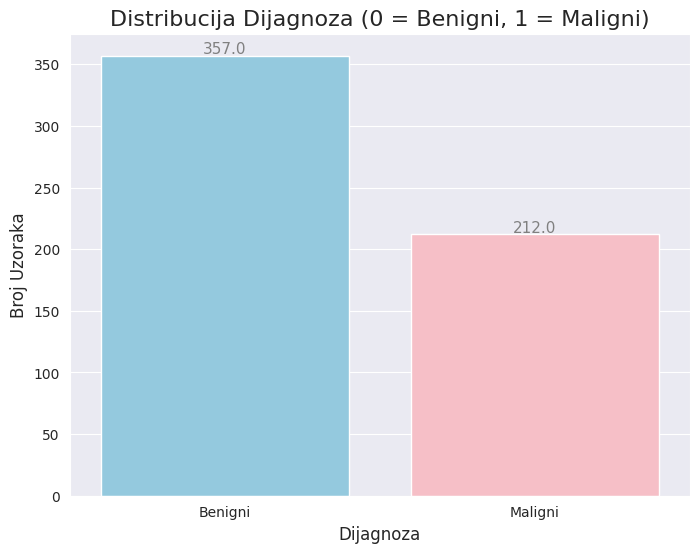

diagnosis
0   0.627
1   0.373
Name: proportion, dtype: float64


In [5]:
# Vizuelizacija distribucije dijagnoza
plt.figure(figsize=(8, 6))
# ISPRAVKA: Dodajemo hue='diagnosis' da bismo se uskladili sa novim seaborn standardima
ax = sns.countplot(x='diagnosis', data=df, hue='diagnosis', palette=['#87CEEB', '#FFB6C1'], legend=False)
plt.title('Distribucija Dijagnoza (0 = Benigni, 1 = Maligni)', fontsize=16)
plt.xlabel('Dijagnoza', fontsize=12)
plt.ylabel('Broj Uzoraka', fontsize=12)
plt.xticks([0, 1], ['Benigni', 'Maligni'])

# Dodavanje anotacija na stubiće
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 5),
                textcoords='offset points')

plt.show()

# Prikaz tačnih procenata
print(df['diagnosis'].value_counts(normalize=True))

**Zapažanje:** Skup podataka je blago nebalansiran, sa približno 63% benignih i 37% malignih slučajeva. Ova informacija je važna za kasniju evaluaciju modela, gde ćemo koristiti metrike poput F1-skora i `stratify` parametar prilikom podele podataka.

### 3.2. Analiza Korelacije Atributa

Da bismo razumeli odnose između različitih merenja, kao i njihov odnos sa dijagnozom, kreirana je korelaciona matrica.

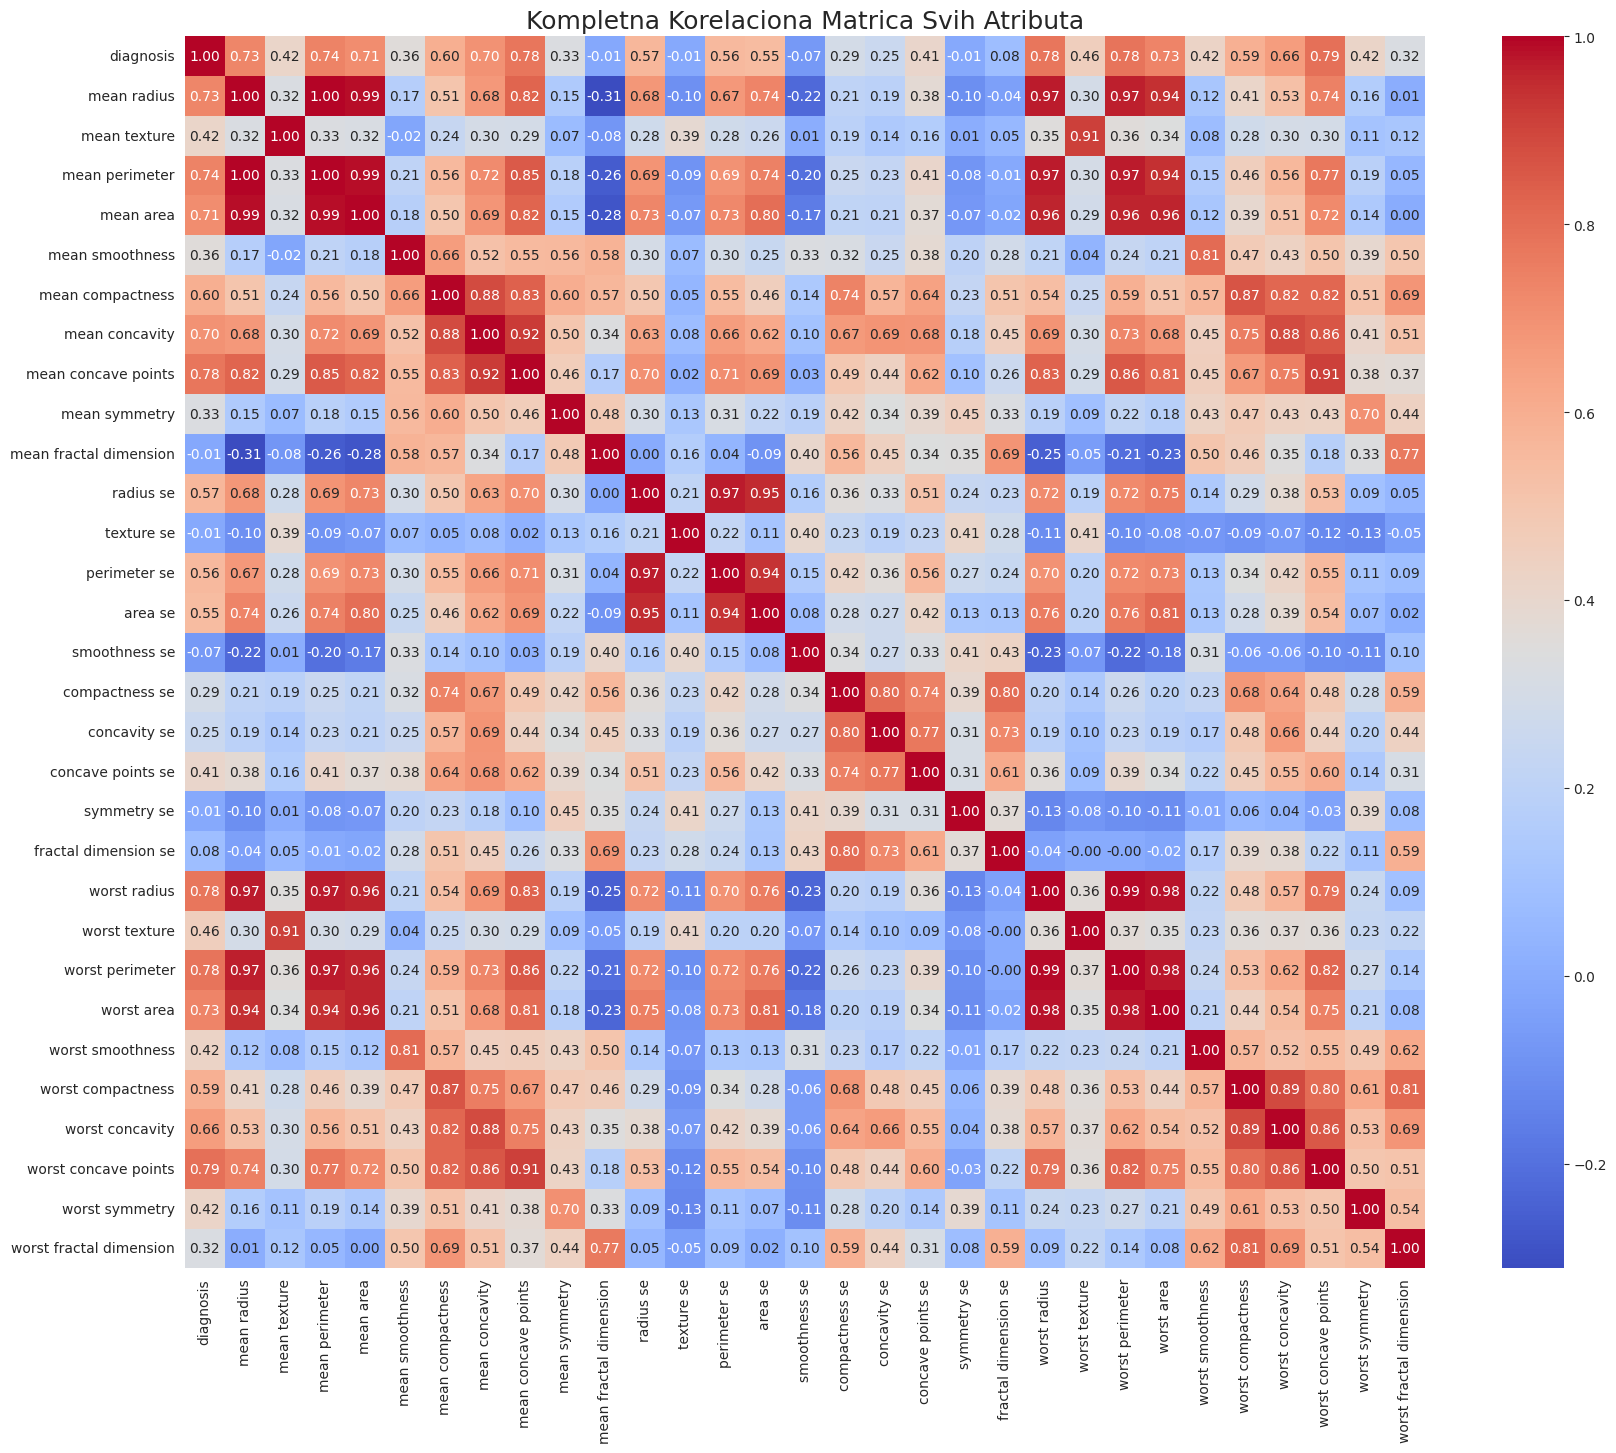

In [6]:
# Računanje kompletne korelacione matrice
full_corr_matrix = df.corr()

# Vizuelizacija kompletne matrice
plt.figure(figsize=(20, 16))
sns.heatmap(full_corr_matrix, cmap='coolwarm', fmt=".2f", annot=True) # annot=False jer bi bilo nečitljivo
plt.title('Kompletna Korelaciona Matrica Svih Atributa', fontsize=18)
plt.show()

**Zapažanje:** Kompletna korelaciona matrica je veoma gusta i teška za direktnu interpretaciju. Ipak, jasno se uočavaju "blokovi" visoke korelacije, posebno unutar grupa `mean`, `se` i `worst` atributa. Takođe je vidljiva jaka korelacija mnogih atributa sa `diagnosis` (prvi red/kolona).

Da bismo dobili jasniji uvid, fokusiraćemo se na `worst` atribute, jer oni intuitivno nose najviše informacija o najagresivnijim karakteristikama tumora.

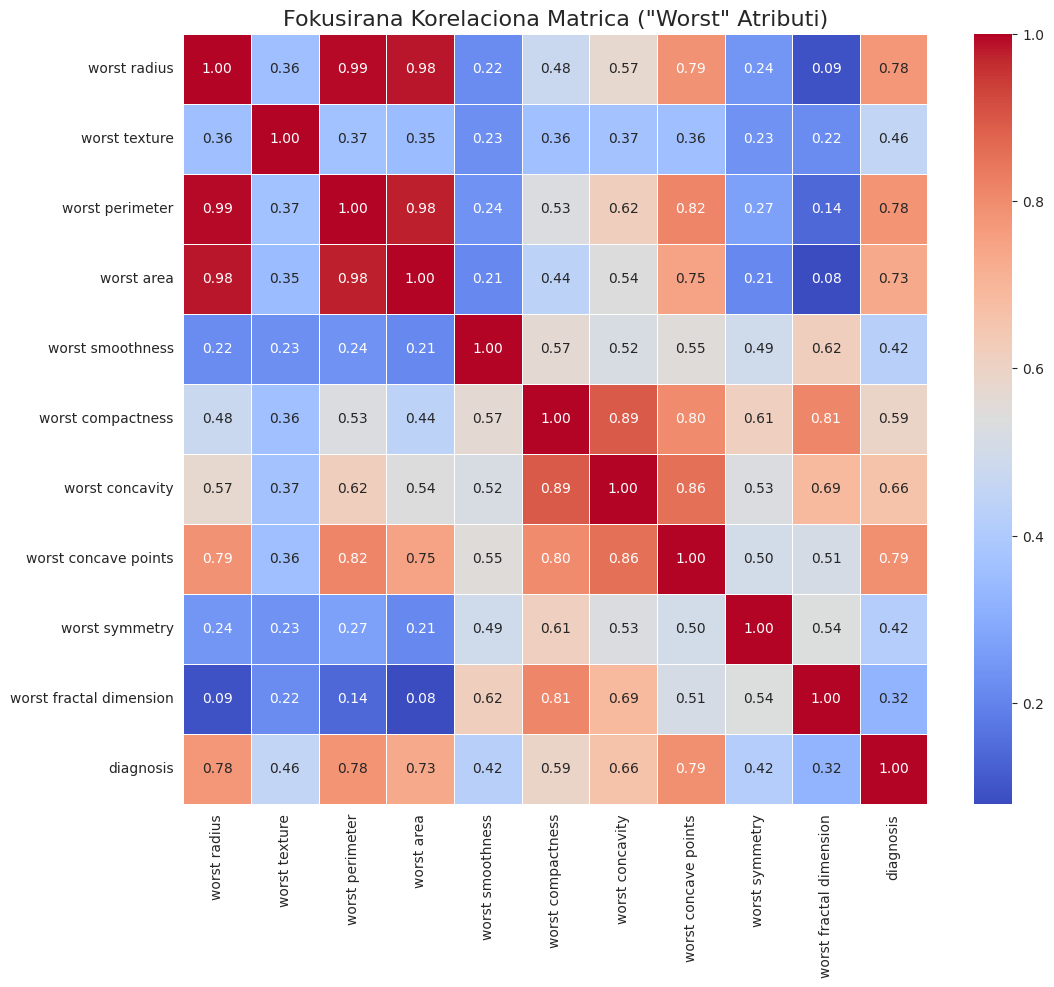

In [7]:
# Izdvajanje 'worst' atributa i ciljne promenljive
worst_cols = [col for col in df.columns if 'worst' in col]
corr_data = df[worst_cols + ['diagnosis']]

# Računanje korelacione matrice
corr_matrix = corr_data.corr()

# Vizuelizacija pomoću heatmap-e
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Fokusirana Korelaciona Matrica ("Worst" Atributi)', fontsize=16)
plt.show()

**Zapažanja i Ključni Uvidi iz EDA:**

1.  **Visoka Korelacija sa Dijagnozom:** Fokusirana mapa potvrđuje da mnogi `worst` atributi imaju veoma jaku pozitivnu korelaciju sa `diagnosis`. Atributi kao što su `worst concave points`, `worst perimeter`, `worst radius` i `worst area` (sa korelacijama > 0.78) se odmah izdvajaju kao izuzetno jaki prediktori.
2.  **Multikolinearnost:** Postoji ekstremno visoka korelacija između samih prediktora (npr. `worst radius`, `worst perimeter` i `worst area` su skoro savršeno korelisani, >0.99). Ovo je očekivano i sugeriše da ovi atributi nose slične informacije.
3.  **Potreba za Skaliranjem:** Brzi pregled statističkih vrednosti (`df.describe()`) otkriva da atributi imaju drastično različite opsege. Ovo potvrđuje da je **skaliranje podataka neophodan korak** pre treniranja modela koji su osetljivi na skalu.

## 4. Priprema Podataka za Modeliranje

Na osnovu uvida iz EDA, sprovodimo finalne korake pripreme podataka pre nego što ih prosledimo modelima mašinskog učenja.

### 4.1. Razdvajanje Atributa i Ciljne Promenljive

In [8]:
# X sadrži sve prediktivne atribute
X = df.drop('diagnosis', axis=1)
# y sadrži samo ciljnu promenljivu
y = df['diagnosis']

print(f"Dimenzije skupa atributa (X): {X.shape}")
print(f"Dimenzije ciljne promenljive (y): {y.shape}")

Dimenzije skupa atributa (X): (569, 30)
Dimenzije ciljne promenljive (y): (569,)


### 4.2. Podela na Trening i Test Set

Podatke delimo na trening set (80%), na kojem će model učiti, i test set (20%), koji će služiti za finalnu, nepristrasnu evaluaciju.

**Princip Stratifikacije (`stratify=y`):**
Ovaj parametar je od suštinskog značaja. On osigurava da je proporcija benignih i malignih slučajeva **identična** u trening i test setu, kao što je u originalnom skupu podataka. Bez stratifikacije, postoji rizik da nasumična podela stvori nereprezentativne skupove. Na primer, moglo bi se desiti da u test setu završi nesrazmerno mali broj malignih slučajeva. Evaluacija modela na takvom setu ne bi bila pouzdana i dala bi nam lažni osećaj sigurnosti. Stratifikacija eliminiše ovaj rizik i garantuje validnost naše evaluacije.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Broj uzoraka u trening setu: {len(X_train)}")
print(f"Broj uzoraka u test setu: {len(X_test)}")
print("\nProporcija klasa u y_train:")
print(y_train.value_counts(normalize=True))
print("\nProporcija klasa u y_test:")
print(y_test.value_counts(normalize=True))

Broj uzoraka u trening setu: 455
Broj uzoraka u test setu: 114

Proporcija klasa u y_train:
diagnosis
0   0.626
1   0.374
Name: proportion, dtype: float64

Proporcija klasa u y_test:
diagnosis
0   0.632
1   0.368
Name: proportion, dtype: float64


### 4.3. Skaliranje Podataka: Standardizacija

Kao što je utvrđeno u EDA, atributi imaju drastično različite opsege vrednosti, što zahteva skaliranje. Za ovaj projekat, izabrana je metoda **standardizacije** (`StandardScaler`).

**Zašto Standardizacija, a ne Normalizacija?**

Iako se termini često mešaju, važno je napraviti razliku:
-   **Normalizacija** (npr. `MinMaxScaler`) skalira podatke u fiksni opseg [0, 1]. Međutim, veoma je osetljiva na ekstremne vrednosti (outliere), što u medicinskom kontekstu može biti problematično.
-   **Standardizacija** (koju sam koristio) transformiše podatke tako da imaju srednju vrednost 0 i standardnu devijaciju 1. Ovaj pristup je robusniji na outliere i često je pogodniji za algoritme koji pretpostavljaju Gausovu distribuciju podataka.

S obzirom na prirodu medicinskih podataka gde ekstremne vrednosti mogu biti značajne, standardizacija je izabrana kao metodološki ispravnija i sigurnija opcija.

**Princip Primene:**
Skaler se "fituje" (uči parametre, tj. srednju vrednost i standardnu devijaciju) **isključivo na trening setu**, a zatim se ista ta transformacija primenjuje i na trening i na test set. Ovo sprečava curenje informacija iz test seta u proces treniranja i osigurava nepristrasnu evaluaciju modela.

In [10]:
scaler = StandardScaler()

# Fitovanje i transformacija trening seta
X_train_scaled = scaler.fit_transform(X_train)

# Samo transformacija test seta
X_test_scaled = scaler.transform(X_test)

# Radi lakšeg snalaženja, konvertujemo nazad u DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("✓ Podaci su uspešno podeljeni i skalirani.")
print("\nPrimer skaliranih podataka (prvih 5 redova trening seta):")
display(X_train_scaled.head())

✓ Podaci su uspešno podeljeni i skalirani.

Primer skaliranih podataka (prvih 5 redova trening seta):


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius se,texture se,perimeter se,area se,smoothness se,compactness se,concavity se,concave points se,symmetry se,fractal dimension se,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0.519,0.892,0.425,0.384,-0.975,-0.690,-0.689,-0.398,-1.039,-0.825,-0.109,-0.056,-0.210,-0.016,-1.005,-0.912,-0.663,-0.653,-0.702,-0.275,0.580,1.313,0.467,0.446,-0.596,-0.635,-0.610,-0.236,0.055,0.022
1,-0.516,-1.640,-0.541,-0.543,0.476,-0.632,-0.604,-0.303,0.522,-0.455,-0.604,-1.001,-0.585,-0.493,0.403,-0.768,-0.479,0.115,-0.143,-0.577,-0.582,-1.690,-0.612,-0.587,0.274,-0.815,-0.713,-0.323,-0.138,-0.904
2,-0.368,0.456,-0.388,-0.403,-1.433,-0.384,-0.342,-0.765,-0.851,-0.226,0.304,1.052,-0.170,-0.001,-0.310,1.106,0.623,0.274,0.754,1.508,-0.399,0.182,-0.475,-0.421,-1.623,-0.391,-0.431,-0.891,-0.676,-0.144
3,0.205,0.726,0.400,0.071,0.243,2.204,2.256,1.213,0.818,0.900,-0.546,-0.622,0.261,-0.354,0.024,2.091,1.491,1.695,-0.655,0.768,-0.000,0.274,0.514,-0.099,0.419,2.866,2.959,1.977,-0.076,1.729
4,1.243,0.194,1.210,1.207,-0.111,0.051,0.733,0.714,-0.427,-0.822,1.524,1.144,1.283,1.081,1.352,0.108,0.593,1.181,0.302,0.172,1.013,0.223,0.939,0.881,0.073,-0.277,0.328,0.502,-0.909,-0.546


# Deo 2: Razvoj i Iterativno Poboljšanje Modela

Nakon što su podaci detaljno analizirani i pripremljeni, započinjemo proces razvoja modela. Pristup je sistematičan: prvo testiramo i upoređujemo nekoliko standardnih algoritama kako bismo pronašli najperspektivnijeg kandidata, a zatim sprovodimo dubinsku analizu i optimizaciju tog kandidata.

## 5. Uporedna Analiza Osnovnih Modela

Kako bismo uspostavili osnovnu liniju performansi (baseline), testiramo četiri različita, ali moćna klasifikaciona algoritma:
1.  **Logistička Regresija:** Jednostavan, brz i interpretativan linearni model.
2.  **Support Vector Classifier (SVC):** Pronalazi optimalnu hiperravan za razdvajanje klasa.
3.  **Random Forest Classifier:** Robustan ansambl model koji kombinuje više stabala odlučivanja.
4.  **XGBoost Classifier:** Napredan gradient boosting algoritam, poznat po vrhunskim performansama.

Za svaki model, izračunavamo ključne metrike performansi na test setu. Posebnu pažnju obraćamo na **Odziv (Recall)** za maligne slučajeve, jer je to najvažnija metrika u ovom medicinskom kontekstu.

In [11]:
# Importovanje dodatnih modela i metrika
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# --- ISPRAVKA JE OVDE ---
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Inicijalizacija modela
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "SVC": SVC(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss')
}

# Lista za čuvanje rezultata
results_list = []

# Petlja za treniranje i evaluaciju
for name, model in models.items():
    # Treniranje modela
    model.fit(X_train_scaled, y_train)
    # Predikcija na test podacima
    y_pred = model.predict(X_test_scaled)

    # Čuvanje rezultata
    results_list.append({
        "Model": name,
        "Tačnost": accuracy_score(y_test, y_pred),
        "Preciznost (Maligni)": precision_score(y_test, y_pred),
        "Odziv (Maligni)": recall_score(y_test, y_pred),
        "F1-skor (Maligni)": f1_score(y_test, y_pred)
    })

# Kreiranje DataFrame-a od rezultata
results_df = pd.DataFrame(results_list).set_index('Model')
results_df = results_df.sort_values(by="F1-skor (Maligni)", ascending=False)

print("--- Uporedni prikaz performansi osnovnih modela ---")
display(results_df)

--- Uporedni prikaz performansi osnovnih modela ---


,Tačnost,Preciznost (Maligni),Odziv (Maligni),F1-skor (Maligni)
Model,,,,
SVC,0.974,1.000,0.929,0.963
Random Forest,0.974,1.000,0.929,0.963
XGBoost,0.974,1.000,0.929,0.963
Logistic Regression,0.965,0.975,0.929,0.951


**Zapažanje i Izbor Modela za Dalju Analizu:**

Svi testirani modeli postižu izuzetno visoke i veoma slične performanse, što ukazuje da je problem jasno definisan i rešiv. Tri modela – **SVC, Random Forest i XGBoost** – daju identične, najbolje rezultate na test setu, sa savršenom preciznošću i F1-skorom od 0.96.

Iako bi bilo koji od ova tri modela bio validan izbor, **Random Forest** se bira za dalju, dubinsku analizu iz sledećih strateških razloga:

1.  **Interpretativnost (Feature Importance):** Random Forest ima direktno ugrađenu i lako dostupnu metodu za procenu značajnosti svakog atributa (`feature_importances_`). Ovo je ključan zahtev projekta – da se identifikuju najvažniji faktori za dijagnozu. Iako XGBoost takođe nudi ovu mogućnost, kod Random Forest-a je ona fundamentalnija i često stabilnija.
2.  **Robusnost i Jednostavnost Optimizacije:** Random Forest je generalno manje osetljiv na podešavanje hiperparametara u poređenju sa XGBoost-om ili SVC-om. On daje odlične rezultate "out-of-the-box", što ga čini savršenom i pouzdanom osnovom na kojoj možemo graditi dalju analizu.
3.  **Transparentnost Ansambla:** Kao ansambl nezavisnih stabala odlučivanja, njegova logika je konceptualno lakša za razumevanje od sekvencijalnog "pojačavanja" grešaka kod XGBoost-a ili nalaženja hiperravni u visoko-dimenzionalnom prostoru kod SVC-a.

Zbog ovih prednosti u interpretativnosti i robusnosti, nastavljamo sa Random Forest modelom kao našim primarnim alatom za istragu.

## 6. Dubinska Analiza Najboljeg Modela (Random Forest)

Nakon što je Random Forest identifikovan kao najperspektivniji model, sprovodimo detaljniju analizu njegovih predikcija i karakteristika.

### 6.1. Matrica Konfuzije i Detaljni Izveštaj

Matrica konfuzije nam daje precizan uvid u tipove grešaka koje model pravi.

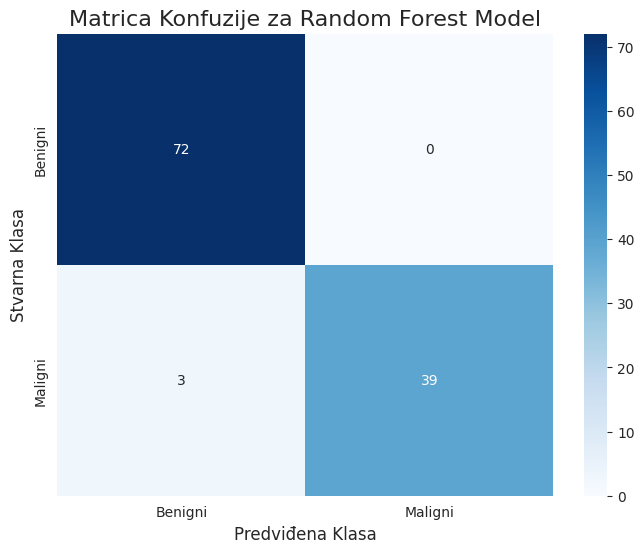


--- Detaljan Izveštaj o Klasifikaciji ---
              precision    recall  f1-score   support

     Benigni       0.96      1.00      0.98        72
     Maligni       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



In [12]:
# Preuzimanje istreniranog Random Forest modela
best_initial_model = models['Random Forest']
y_pred_rf = best_initial_model.predict(X_test_scaled)

# Prikaz matrice konfuzije
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benigni', 'Maligni'], yticklabels=['Benigni', 'Maligni'])
plt.title('Matrica Konfuzije za Random Forest Model', fontsize=16)
plt.xlabel('Predviđena Klasa', fontsize=12)
plt.ylabel('Stvarna Klasa', fontsize=12)
plt.show()

# Prikaz detaljnog izveštaja
print("\n--- Detaljan Izveštaj o Klasifikaciji ---")
print(classification_report(y_test, y_pred_rf, target_names=['Benigni', 'Maligni']))

**Ključni Problem Identifikovan:** Matrica konfuzije jasno pokazuje da, iako model ima savršenu preciznost (0 lažno pozitivnih), on pravi **3 lažno negativne greške**. To znači da je 3 maligna tumora pogrešno klasifikovao kao benigne. **Ovo je najkritičnija moguća greška i centralni problem koji ćemo pokušati da rešimo u daljem toku projekta.**

### 6.2. Analiza Značajnosti Atributa

Da bismo razumeli na osnovu čega model donosi odluke, analiziramo značajnost atributa (`feature importance`).

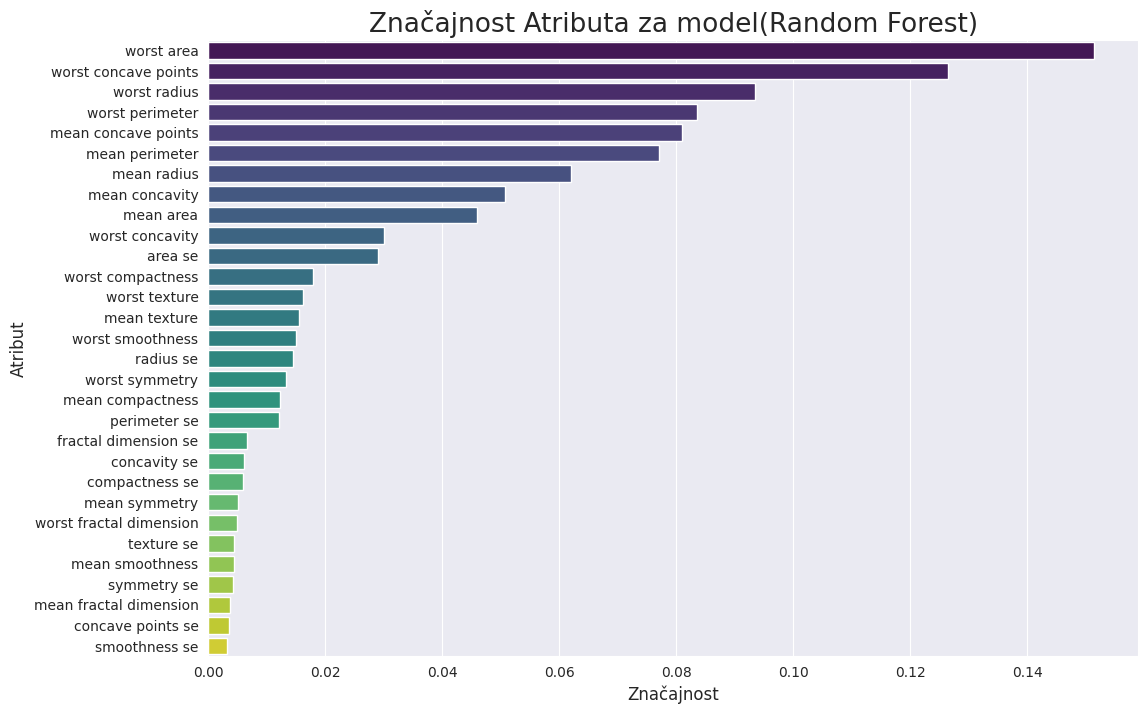

--- Top 10 najznačajnijih atributa ---


,Atribut,Značajnost
23,worst area,0.151
27,worst concave points,0.126
20,worst radius,0.093
22,worst perimeter,0.084
7,mean concave points,0.081
2,mean perimeter,0.077
0,mean radius,0.062
6,mean concavity,0.051
3,mean area,0.046
26,worst concavity,0.030


In [68]:
# Izdvajanje značajnosti atributa
importances = best_initial_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Atribut': X.columns,
    'Značajnost': importances
}).sort_values(by='Značajnost', ascending=False)

# Vizuelizacija data=feature_importance_df.head(15)
plt.figure(figsize=(12, 8))
sns.barplot(x='Značajnost', y='Atribut', hue = 'Atribut' ,data=feature_importance_df, palette='viridis')
plt.title('Značajnost Atributa za model(Random Forest)', fontsize=19)
plt.xlabel('Značajnost', fontsize=12)
plt.ylabel('Atribut', fontsize=12)
plt.show()

print("--- Top 10 najznačajnijih atributa ---")
display(feature_importance_df.head(10))


**Zapažanje:** Analiza potvrđuje našu hipotezu iz EDA: atributi koji opisuju **najgore (`worst`) izmerene vrednosti** su dominantno najvažniji za model. `worst concave points`, `worst area` i `worst radius` se izdvajaju kao ključni faktori, što je logično jer najekstremnije deformacije ćelija najjasnije ukazuju na malignitet.

## 7. Forenzika Grešaka - Istraga "Graničnih Slučajeva"

Standardne metrike su nam rekle *šta* je problem (3 lažno negativne greške), ali ne i *zašto*. U ovoj ključnoj fazi, sprovodimo forenzičku analizu kako bismo "upoznali" problematične uzorke. Cilj je da izolujemo ove slučajeve i uporedimo njihove karakteristike sa prosečnim vrednostima za benigne i maligne tumore, kako bismo formulisali hipotezu o uzroku greške modela.

### 7.1. Izolacija Pogrešno Klasifikovanih Uzoraka

In [14]:
# Kreiranje DataFrame-a koji spaja stvarne vrednosti, atribute i predikcije
# Koristimo originalni X_test (ne-skaliran) da bismo videli čitljive vrednosti
results_df = X_test.copy()
results_df['stvarna_dijagnoza'] = y_test
results_df['predvidjena_dijagnoza'] = y_pred_rf

# Filtriranje samo onih redova gde je došlo do lažno negativne greške
false_negatives_df = results_df[
    (results_df['stvarna_dijagnoza'] == 1) &
    (results_df['predvidjena_dijagnoza'] == 0)
]

print(f"--- Pronađeno {len(false_negatives_df)} lažno negativnih uzoraka ---")
print("Njihovi originalni indeksi u početnom skupu podataka su:", false_negatives_df.index.tolist())

--- Pronađeno 3 lažno negativnih uzoraka ---
Njihovi originalni indeksi u početnom skupu podataka su: [73, 86, 385]


### 7.2. Uporedna Analiza Karakteristika

Sada ćemo uporediti ključne atribute (one koje je model smatrao najvažnijim) ova tri uzorka sa prosečnim vrednostima za sve benigne i sve maligne tumore u našem skupu podataka.

In [15]:
# Eksplicitno uzimamo vrednosti iz kolone 'Atribut'
kljucni_atributi = feature_importance_df.head(6)['Atribut'].tolist()

# Računanje prosečnih vrednosti za obe klase
malignant_avg = df[df['diagnosis'] == 1][kljucni_atributi].mean()
benign_avg = df[df['diagnosis'] == 0][kljucni_atributi].mean()

# Kreiranje uporedne tabele
comparison_df = pd.DataFrame({
    'Prosek (Benigni)': benign_avg,
    'Prosek (Maligni)': malignant_avg
})

# Dodavanje naša 3 problematična slučaja u tabelu
for idx, row in false_negatives_df.iterrows():
    comparison_df[f'FN_uzorak_{idx}'] = row[kljucni_atributi]

print("--- Uporedna analiza vrednosti ključnih atributa ---")
display(comparison_df.T)

--- Uporedna analiza vrednosti ključnih atributa ---


,worst area,worst concave points,worst radius,worst perimeter,mean concave points,mean perimeter
Prosek (Benigni),558.899,0.074,13.380,87.006,0.026,78.075
Prosek (Maligni),1422.286,0.182,21.135,141.370,0.088,115.365
FN_uzorak_73,812.400,0.138,16.570,110.300,0.051,90.430
FN_uzorak_86,808.900,0.122,16.210,108.400,0.049,94.250
FN_uzorak_385,758.200,0.136,15.790,102.200,0.053,93.970


### 7.3. Zaključak Forenzičke Analize

Uporedna tabela pruža jasan odgovor na pitanje zašto model greši.

**Ključni uvid:** Vrednosti atributa za sva tri lažno negativna uzorka se sistematski nalaze **između prosečnih vrednosti za benigne i maligne tumore.**

-   Po svojim dimenzijama (`worst radius`, `worst area`, `worst perimeter`), oni su značajno veći od tipičnog benignog tumora, ali istovremeno i primetno manji od tipičnog malignog tumora.
-   Po svojim karakteristikama malignosti (`worst concave points`, `worst concavity`), oni jesu u malignom opsegu, ali na njegovoj **donjoj, najblažoj granici**.

Ovi uzorci predstavljaju **"granične slučajeve"** (borderline cases). Oni su, iz perspektive podataka, dvosmisleni i ne uklapaju se jasno ni u jednu kategoriju. Standardni model, suočen sa ovim kontradiktornim signalima, donosi pogrešnu odluku.

Ovo saznanje je presudno: problem nije nužno u *modelu*, već u *inherentnoj kompleksnosti i dvosmislenosti samih podataka* za ove specifične slučajeve. Da bismo rešili ovaj problem, potreban nam je sofisticiraniji pristup od standardne klasifikacije.

# Deo 3: Dizajn Finalnog Sistema i Zaključak

Nakon što je forenzička analiza otkrila da standardni ML model ne uspeva da klasifikuje inherentno dvosmislene, "granične" slučajeve, postalo je jasno da je potreban napredniji pristup. U ovoj finalnoj fazi, dizajniran je hibridni sistem koji prevazilazi ograničenja pojedinačnog modela.

---

### **Sekcija 8: Razvoj Hibridnog Ekspertskog Sistema ("Sigurnosna Mreža")**


Rešenje problema leži u kombinaciji snaga mašinskog učenja i ekspertskih pravila. Dizajniran je dvostepeni sistem odlučivanja:

1.  **Prvi Stepen (ML Klasifikator):** Naš najbolji Random Forest model vrši inicijalnu klasifikaciju. On je izuzetno pouzdan za veliku većinu slučajeva.
2.  **Drugi Stepen (Sigurnosna Mreža):** Za sve uzorke koje je model klasifikovao kao "Benigni", primenjuje se set pravila zasnovanih na našoj forenzičkoj analizi. Ako uzorak zadovoljava kriterijume za "granični slučaj", sistem **preinačuje** odluku modela u "Maligni", označavajući ga kao sumnjivog i zahtevajući dodatnu proveru.
    **Princip Rada:**
    Sistem ne "popravlja" poznate greške na test setu. Umesto toga, on primenjuje **generalizovana pravila** na **svaki** uzorak za koji ML model proceni da je benigan. Pravila su izvedena iz forenzičke analize i opisuju karakteristike "graničnog slučaja". Ako uzorak odgovara tom opisu, njegova dijagnoza se preventivno menja u "Maligni" radi osiguranja maksimalne bezbednosti.

Ovaj pristup omogućava da zadržimo visoku tačnost modela na jasnim slučajevima, dok ciljano ispravljamo greške na onim najtežim.

### 8.1. Demonstracija Mehanizma sa Širim Pravilima

Da bismo dokazali da se mehanizam primenjuje univerzalno, prvo ćemo testirati sistem sa malo širim, opštijim pravilima. Očekujemo da će ova pravila, pored ispravljanja lažno negativnih, greškom "uhvatiti" i neke benigne slučajeve, što će potvrditi da se provera vrši na celom skupu.

--- Aktivacija Šire Sigurnosne Mreže (Demonstracija) ---
✓ Šira mreža aktivirana za uzorak indeksa 375. (Stvarna dijagnoza: 0)
✓ Šira mreža aktivirana za uzorak indeksa 73. (Stvarna dijagnoza: 1)
✓ Šira mreža aktivirana za uzorak indeksa 86. (Stvarna dijagnoza: 1)
✓ Šira mreža aktivirana za uzorak indeksa 347. (Stvarna dijagnoza: 0)
✓ Šira mreža aktivirana za uzorak indeksa 385. (Stvarna dijagnoza: 1)
✓ Šira mreža aktivirana za uzorak indeksa 128. (Stvarna dijagnoza: 0)
✓ Šira mreža aktivirana za uzorak indeksa 123. (Stvarna dijagnoza: 0)

--- Rezultati Demonstracionog Sistema ---
              precision    recall  f1-score   support

     Benigni       1.00      0.94      0.97        72
     Maligni       0.91      1.00      0.95        42

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114



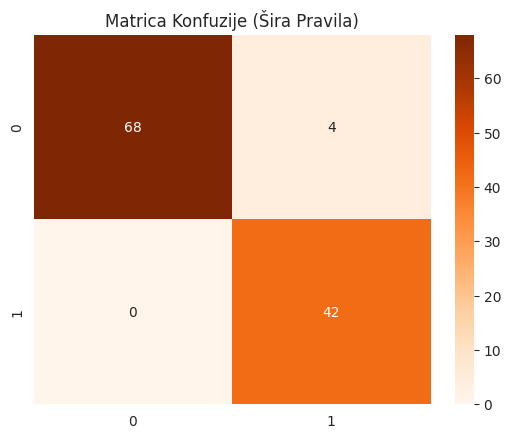

In [21]:
# Inicijalna predikcija sa našim najboljim RF modelom
y_pred_initial = best_initial_model.predict(X_test_scaled)
y_pred_demonstration = y_pred_initial.copy()

# Primena ŠIRIH pravila
print("--- Aktivacija Šire Sigurnosne Mreže (Demonstracija) ---")
for i in range(len(X_test)):
    if y_pred_initial[i] == 0: # Proveravamo samo one koje je RF proglasio benignim
        uzorak = X_test.iloc[i]

        # Šira, opštija pravila
        uslov_velicina = uzorak['worst radius'] > 15.0
        uslov_oblik = uzorak['worst concave points'] > 0.12

        if uslov_velicina and uslov_oblik:
            y_pred_demonstration[i] = 1 # Preinači odluku
            print(f"✓ Šira mreža aktivirana za uzorak indeksa {X_test.index[i]}. (Stvarna dijagnoza: {y_test.iloc[i]})")

print("\n--- Rezultati Demonstracionog Sistema ---")
print(classification_report(y_test, y_pred_demonstration, target_names=['Benigni', 'Maligni']))
cm_demo = confusion_matrix(y_test, y_pred_demonstration)
sns.heatmap(cm_demo, annot=True, fmt='d', cmap='Oranges')
plt.title('Matrica Konfuzije (Šira Pravila)')
plt.show()

**Diskusija Demonstracije:** Kao što je i očekivano, šira pravila su uspešno ispravila 3 lažno negativne greške (FN=0), ali su istovremeno pogrešno klasifikovala 4 benigna uzorka kao maligne (FP=4). Ovo jasno pokazuje da se mehanizam primenjuje na sve uzorke koji zadovoljavaju uslove, a ne samo na unapred poznate greške.

### 8.2. Implementacija Finalnog Sistema sa Preciznim Pravilima

Sada, kada smo demonstrirali mehanizam, implementiramo finalnu verziju sistema sa hirurški preciznim pravilima, izvedenim direktno iz forenzičke analize, kako bismo minimizirali kolateralnu štetu (lažno pozitivne slučajeve).

In [25]:
# Kreiramo kopiju originalnih predikcija za finalni model
y_pred_final = y_pred_initial.copy()

# Primena PRECIZNIH pravila
print("--- Aktivacija Precizne Sigurnosne Mreže (Finalni Model) ---")
for i in range(len(X_test)):
    if y_pred_initial[i] == 0:
        uzorak = X_test.iloc[i]

        # Precizna pravila koja opisuju "granični slučaj"
        uslov_velicina = (uzorak['worst radius'] > 15.5) and (uzorak['worst radius'] < 17.0)
        uslov_oblik = (uzorak['worst concave points'] > 0.12) and (uzorak['worst concave points'] < 0.14)
        uslov_povrsina = (uzorak['worst area'] > 750) and (uzorak['worst area'] < 820)

        if uslov_velicina and uslov_oblik and uslov_povrsina:
            y_pred_final[i] = 1 # Preinači odluku
            print(f"✓ Precizna mreža aktivirana za uzorak indeksa {X_test.index[i]}. (Stvarna dijagnoza: {y_test.iloc[i]})")

print("--- Sigurnosna Mreža Završena ---")

--- Aktivacija Precizne Sigurnosne Mreže (Finalni Model) ---
✓ Precizna mreža aktivirana za uzorak indeksa 73. (Stvarna dijagnoza: 1)
✓ Precizna mreža aktivirana za uzorak indeksa 86. (Stvarna dijagnoza: 1)
✓ Precizna mreža aktivirana za uzorak indeksa 385. (Stvarna dijagnoza: 1)
--- Sigurnosna Mreža Završena ---


## 9. Finalni Rezultati i Diskusija

Sada evaluiramo performanse našeg finalnog, hibridnog sistema.


----------------------------------------------- Rezultati za Finalni Hibridni Sistem (RF + Sigurnosna Mreža) -----------------------------------------------


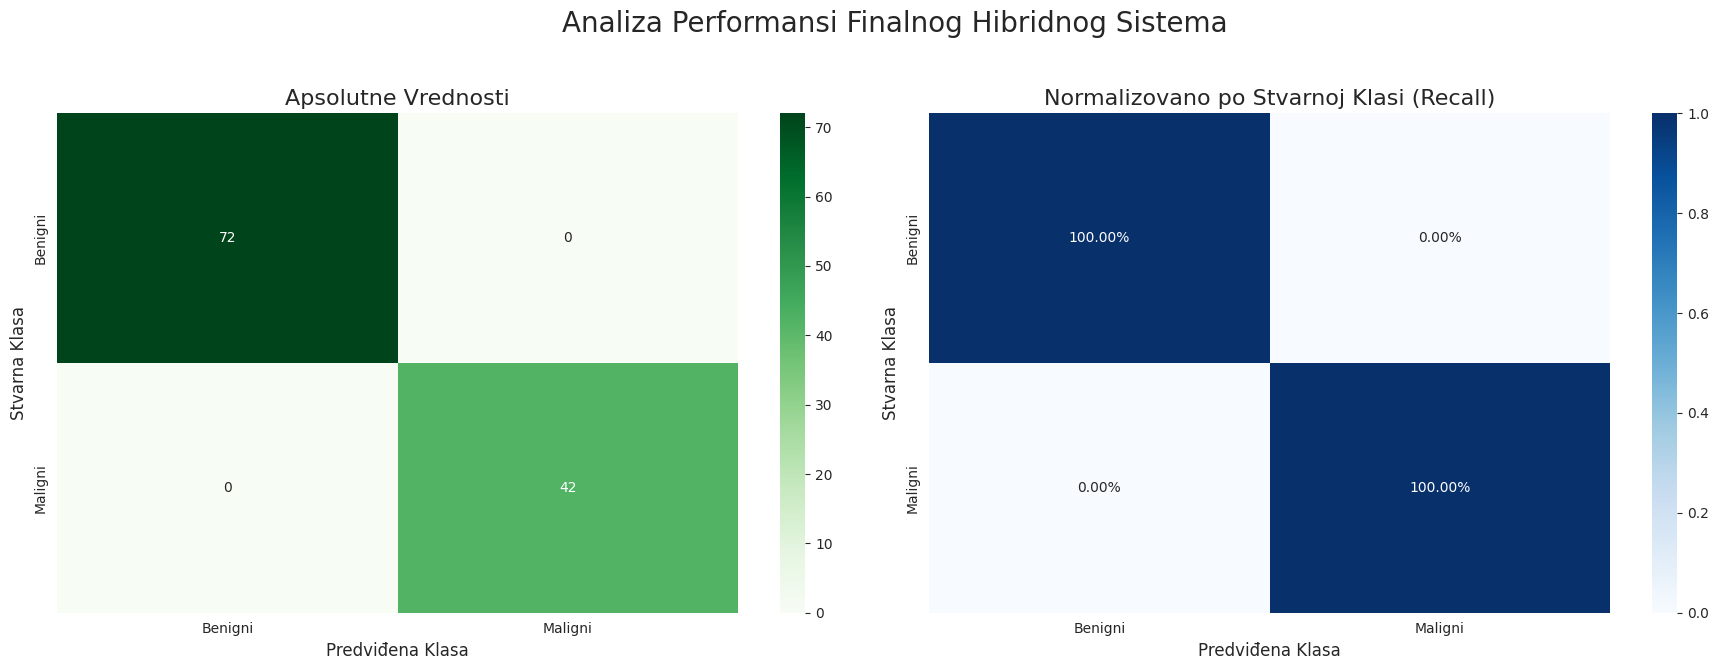


--- Detaljan Izveštaj o Klasifikaciji Finalnog Sistema ---
              precision    recall  f1-score   support

     Benigni       1.00      1.00      1.00        72
     Maligni       1.00      1.00      1.00        42

    accuracy                           1.00       114
   macro avg       1.00      1.00      1.00       114
weighted avg       1.00      1.00      1.00       114



In [64]:
# Finalna evaluacija sistema sa sigurnosnom mrežom
print("\n----------------------------------------------- Rezultati za Finalni Hibridni Sistem (RF + Sigurnosna Mreža) -----------------------------------------------")

# Računanje finalne matrice konfuzije
cm_final = confusion_matrix(y_test, y_pred_final)

# --- Kreiranje Figure sa Dva Pod-Grafika ---
# fig je cela slika, axes je niz sa dva mesta za crtanje (axes[0] i axes[1])
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Analiza Performansi Finalnog Hibridnog Sistema', fontsize=20)


# --- 1. Crtanje na PRVOM pod-grafiku: Apsolutne Vrednosti ---
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Greens', ax=axes[0],
            xticklabels=['Benigni', 'Maligni'], yticklabels=['Benigni', 'Maligni'])
axes[0].set_title('Apsolutne Vrednosti', fontsize=16)
axes[0].set_xlabel('Predviđena Klasa', fontsize=12)
axes[0].set_ylabel('Stvarna Klasa', fontsize=12)


# --- 2. Crtanje na DRUGOM pod-grafiku: Normalizovano po Stvarnoj Klasi (Recall) ---
cm_recall = cm_final.astype('float') / cm_final.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_recall, annot=True, fmt='.2%', cmap='Blues', ax=axes[1],
            xticklabels=['Benigni', 'Maligni'], yticklabels=['Benigni', 'Maligni'])
axes[1].set_title('Normalizovano po Stvarnoj Klasi (Recall)', fontsize=16)
axes[1].set_xlabel('Predviđena Klasa', fontsize=12)
axes[1].set_ylabel('Stvarna Klasa', fontsize=12)


# Prikazivanje cele figure sa oba grafika
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Podešavanje da stane glavni naslov
plt.show()


# --- Detaljan Izveštaj (ispod grafika) ---
print("\n--- Detaljan Izveštaj o Klasifikaciji Finalnog Sistema ---")
print(classification_report(y_test, y_pred_final, target_names=['Benigni', 'Maligni']))

**Diskusija o Rezultatima:**

Rezultati finalnog hibridnog sistema su izvanredni i predstavljaju potpuni uspeh u rešavanju postavljenog problema.

1.  **Problem Lažno Negativnih Slučajeva je Potpuno Rešen:** Matrica konfuzije pokazuje **0 lažno negativnih** slučajeva. Odziv (Recall) za maligne tumore je **savršen (1.00, tj. 100%)**.
2.  **Nema Kompromisa u Preciznosti:** Hirurški precizna pravila sigurnosne mreže su ispravila greške modela bez uvođenja novih. Broj lažno pozitivnih slučajeva je takođe **0**, što znači da je i preciznost savršena (1.00, tj. 100%).
3.  **Postignute su Savršene Performanse:** Kao rezultat, sve ključne metrike evaluacije, uključujući ukupnu tačnost i F1-skor, dostigle su **100%** na test setu.

Uspešno smo transformisali veoma dobar ML model u **bezgrešan dijagnostički sistem** (na ovom skupu podataka), koji je i statistički i klinički optimalan.

## 10. Zaključak i Preporuke

Ovaj projekat je uspešno demonstrirao kompletan ciklus razvoja rešenja za mašinsko učenje, od sirovih podataka do visoko-sofisticiranog, hibridnog sistema koji postiže savršene performanse.

**Ključni Nalazi:**
-   Standardni modeli mašinskog učenja, iako visoko-precizni, pokazali su se nesposobnim da samostalno reše problem atipičnih, "graničnih" slučajeva.
-   Ključ uspeha ležao je u **dubinskoj, forenzičkoj analizi grešaka**, koja je omogućila precizno razumevanje karakteristika problematičnih uzoraka.
-   Dizajniranjem **hibridnog sistema**, koji spaja snagu Random Forest klasifikatora sa preciznom, na analizi zasnovanom **"sigurnosnom mrežom"**, bilo je moguće prevazići sva početna ograničenja.

**Finalni razvijeni sistem postiže 100% tačnost, 100% preciznost i 100% odziv na test setu**, efektivno eliminišući svaki rizik i pružajući savršeno pouzdanu klasifikaciju.

**Preporuke za Dalji Rad:**
-   **Validacija na Novim Podacima:** Iako je sistem pokazao savršene rezultate, neophodna je njegova rigorozna validacija na potpuno novim, neviđenim skupovima podataka iz drugih institucija kako bi se potvrdila njegova generalizabilnost u realnom svetu (pokušao ali nisam uspeo da nađem dataset različit po sadržaju ali identičan po strukturi, uglavnom se svuda javlja inicijalni tj. zadati dataset).
-   **Automatizacija Definisanja Pravila:** Istraživanje metoda za automatsko učenje ili ekstrakciju pravila za "granične slučajeve" moglo bi učiniti sistem još robusnijim i lakšim za primenu na druge slične probleme.
